In [377]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import glob
import time
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.model_selection import ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


## Data Preparation

In [375]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'

TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TEST_DATA_PATH=f'{DATASET_PATH}/stage_2_test'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/stage_2_train.csv'
TEST_METADATA_PATH=f'{DATASET_PATH}/stage_2_sample_submission.csv'
TRAIN_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/train_metadata_noidx.csv'
TEST_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/test_metadata_noidx.csv'

In [376]:
class ImagePreparationUtil:
    @staticmethod
    def correct_dcm(dcm: pydicom.FileDataset):
        x = dcm.pixel_array
        x = x + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    @staticmethod
    def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            ImagePreparationUtil.correct_dcm(dcm)
        
        # Pixel to Hounsfield Unit (HU)
        # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
        img = dcm.pixel_array
        img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img
    
    @staticmethod
    def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
        im = None
        match window:
            case 'brain':
                brain_img = ImagePreparationUtil.window_image(dcm, 40, 80)
                brain_img = (brain_img - 0) / 80
                im = brain_img
            case 'subdural':
                subdural_img = ImagePreparationUtil.window_image(dcm, 80, 200)
                subdural_img = (subdural_img - (-20)) / 200
                im = subdural_img
            case 'soft':
                soft_img = ImagePreparationUtil.window_image(dcm, 40, 380)
                soft_img = (soft_img - (-150)) / 380
                im = soft_img
            case _:
                raise ValueError('invalid window argument')
        
        return im
    
    @staticmethod
    def bsb_window(dcm):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')

        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img
    
    @staticmethod
    def read(path, resize: Tuple[int, int]):
        img = None
        try:
            dcm = pydicom.dcmread(path)
            img = ImagePreparationUtil.bsb_window(dcm)
        except Exception as e:
            print('\nWarning:', e.__class__.__name__, f'for {path} Replacing with zeros image')
            img = np.zeros((*tuple(resize[:2]), 3), dtype=np.float32)
        
        if resize is not None:
            img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_LINEAR)
            
        return img.astype(np.float32)

In [10]:
class MetadataLoader:
    def __init__(self, train_metadata_path = TRAIN_METADATA_PATH, test_metadata_path = TEST_METADATA_PATH, lazy_load = True):
      self.train_metadata_path = train_metadata_path
      self.test_metadata_path = test_metadata_path
      self._lazy_load = lazy_load
      self._train_df = None
      self._test_df = None
      
      if not self._lazy_load:
        self._load_trainset()
        self._load_testset()
        
    def _read(self, is_read_train_metadata = True):
        csv_file = self.train_metadata_path
        if not is_read_train_metadata:
            csv_file = self.test_metadata_path
            
        df = pd.read_csv(csv_file)
        
        df["Image"] = df["ID"].str.slice(stop=12)
        df["Diagnosis"] = df["ID"].str.slice(start=13)
        
        if is_read_train_metadata:
            duplicates_to_remove = [
                56346, 56347, 56348, 56349,
                56350, 56351, 1171830, 1171831,
                1171832, 1171833, 1171834, 1171835,
                3705312, 3705313, 3705314, 3705315,
                3705316, 3705317, 3842478, 3842479,
                3842480, 3842481, 3842482, 3842483
            ]
            df = df.drop(index=duplicates_to_remove)
            df = df.reset_index(drop=True)
        
        df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
        df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
        
        return df
    
    def sync_with_actual_file(self):
        """
        Some files maybe didn't contain legitimate images, so we need to remove them from dataframe if any
        """
        if self._train_df is None:
            self._load_trainset()
        
        dcms = glob.glob(os.path.join(TRAIN_DATA_PATH, '*.dcm'))
        dcms = [os.path.basename(dcm)[:-4] for dcm in dcms]
        
        self._train_df = self._train_df[self._train_df.index.isin(dcms)]
        


    def _load_trainset(self):
        self._train_df = self._read(is_read_train_metadata=True)
    
    def _load_testset(self):
        self._test_df = self._read(is_read_train_metadata=False)
    
    def reload_set(self):
        self._load_trainset()
        self._load_testset()
    
    @property
    def train_df(self):
        if self._train_df is not None:
            return self._train_df
        self._load_trainset()
        return self._train_df
    
    @property
    def test_df(self):
        if self._test_df is not None:
            return self._test_df
        self._load_testset()
        return self._test_df

### EDA

In [11]:
def plot_data_distribution(df, legend_suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(legend_suptitle)
    sns.countplot(data=df['Label'], x='any', hue='any',  ax=axes[0], palette='Reds')
    axes[0].set_title("Distribution of ICH Diagnoses (Positive vs Negative)")
    axes[0].set_xlabel("ICH Diagnosis (0=Negative, 1=Positive)")
    axes[0].set_ylabel('Count')
    for c in axes[0].containers:
        axes[0].bar_label(c , fmt=lambda x: f'{(x/df["Label"]["any"].count())*100:0.1f}%')

    df_label_counts = df['Label'].sum(axis=0)[1:].reset_index()
    df_label_counts.columns = ['Label', 'Count']
        
    sns.barplot(x='Label', y='Count', data=df_label_counts, hue='Label' , palette='Set2')
    axes[1].set_title('Percentage of Positive Occurrences by ICH Type')
    axes[1].set_xlabel('ICH Type')
    axes[1].set_ylabel('Positive Occurrence (%)')
    plt.setp(axes[1].get_xticklabels(), rotation=45)
    for c in axes[1].containers:
        axes[1].bar_label(c ,fmt=lambda x: f'{x/len(df.index)*100:0.01f}%')

#### Original

In [12]:
df_loader = MetadataLoader()
df = df_loader.train_df

In [13]:
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_ffff82e46     0        0                0                0            0   
ID_ffff922b9     1        0                0                1            0   
ID_ffffb670a     1        0                0                0            1   
ID_ffffcbff8     0        0                0                0            0   
ID_fffff9393     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
...               ...  
ID_ffff82e46        0  
ID_ffff922b9        0  
ID_ffffb670a        0  
ID_ffffcbff8        0  
ID_fffff9393        0  

[752803 rows x 6 columns]

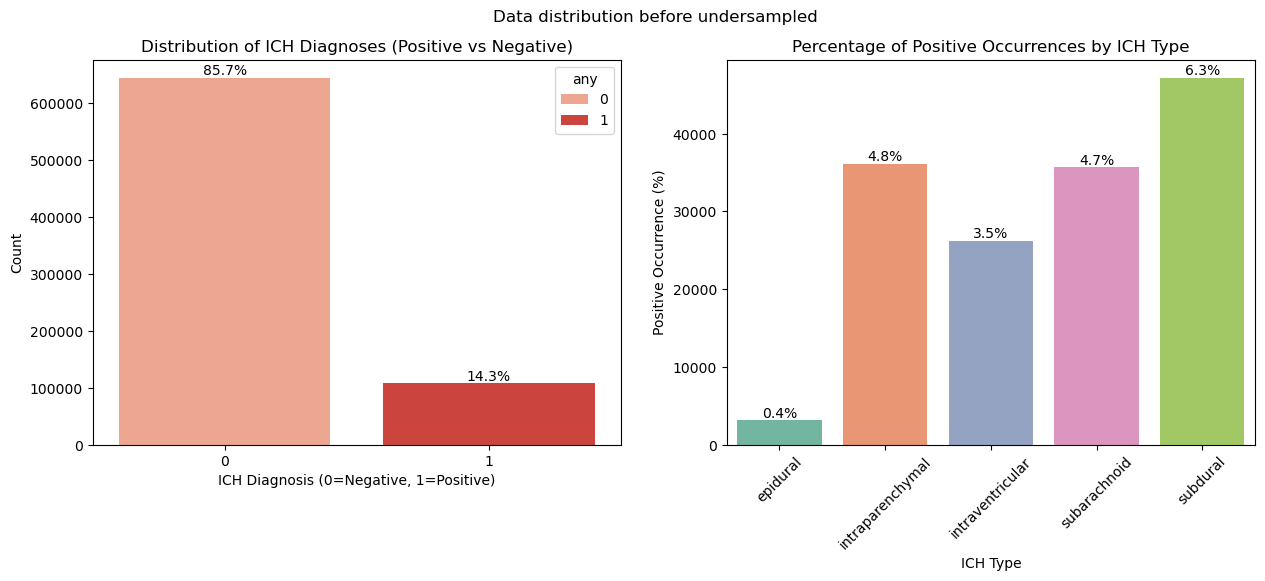

In [14]:
plot_data_distribution(df, 'Data distribution before undersampled')

#### Undersampled Data
remove excessive negative diagnosis

In [15]:
df['Label']['any'].value_counts()

any
0    644870
1    107933
Name: count, dtype: int64

In [16]:
num_positive_diag = df['Label'][df['Label']['any'] == 1].shape[0]

In [17]:
df_negative_diag_selection = df[df['Label']['any'] == 0].sample(n=num_positive_diag, random_state=42, replace=False)
df_negative_diag_selection

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_1c6bfb61e     0        0                0                0            0   
ID_c59dfca21     0        0                0                0            0   
ID_f339f98d4     0        0                0                0            0   
ID_bfd1b9b9f     0        0                0                0            0   
ID_0c0326411     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_75253a3fb     0        0                0                0            0   
ID_99dbd823d     0        0                0                0            0   
ID_a3fcf0fe8     0        0                0                0            0   
ID_6b874c8e4     0        0                0                0            0   
ID_9a1f919ea     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_1c6bfb61e        0  
ID_c59dfca21        0  
ID_f339f98d4        0  
ID_bfd1b9b9f        0  
ID_0c0326411        0  
...               ...  
ID_75253a3fb        0  
ID_99dbd823d        0  
ID_a3fcf0fe8        0  
ID_6b874c8e4        0  
ID_9a1f919ea        0  

[107933 rows x 6 columns]

In [18]:
df = df[(df['Label']['any'] == 1) | df.index.isin(df_negative_diag_selection.index.values)]
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_00005679d     0        0                0                0            0   
ID_0000ca2f6     0        0                0                0            0   
ID_0000f1657     0        0                0                0            0   
ID_0001de0e8     0        0                0                0            0   
ID_0002081b6     1        0                1                0            0   
...            ...      ...              ...              ...          ...   
ID_ffff3212e     0        0                0                0            0   
ID_ffff922b9     1        0                0                1            0   
ID_ffffb670a     1        0                0                0            1   
ID_ffffcbff8     0        0                0                0            0   
ID_fffff9393     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_00005679d        0  
ID_0000ca2f6        0  
ID_0000f1657        0  
ID_0001de0e8        0  
ID_0002081b6        0  
...               ...  
ID_ffff3212e        0  
ID_ffff922b9        0  
ID_ffffb670a        0  
ID_ffffcbff8        0  
ID_fffff9393        0  

[215866 rows x 6 columns]

In [20]:
df = df.sample(frac=1, random_state=666)
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_1be5897b7     0        0                0                0            0   
ID_45b46bd6a     1        0                0                1            0   
ID_60603b903     0        0                0                0            0   
ID_da37a4afc     0        0                0                0            0   
ID_de88a5f54     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_e2088982c     0        0                0                0            0   
ID_9b68c3f5f     0        0                0                0            0   
ID_480eee979     1        0                0                0            0   
ID_7d43d0fdd     0        0                0                0            0   
ID_73d7f1dc8     1        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_1be5897b7        0  
ID_45b46bd6a        0  
ID_60603b903        0  
ID_da37a4afc        0  
ID_de88a5f54        0  
...               ...  
ID_e2088982c        0  
ID_9b68c3f5f        0  
ID_480eee979        1  
ID_7d43d0fdd        0  
ID_73d7f1dc8        1  

[215866 rows x 6 columns]

In [ ]:
df['Label']['any'].value_counts()

any
0    107933
1    107933
Name: count, dtype: int64

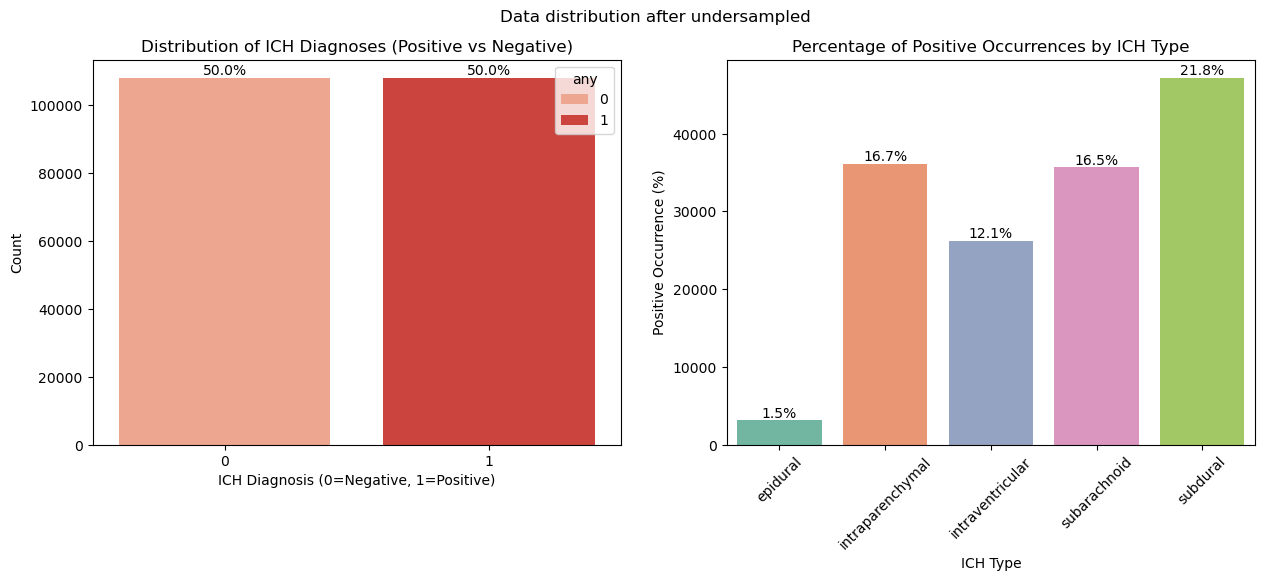

In [22]:
plot_data_distribution(df, 'Data distribution after undersampled')

## Training phase

In [16]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))
  

def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

class_weights_loss_const = K.constant([2., 1., 1., 1., 1., 1.])
def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = class_weights_loss_const
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

I0000 00:00:1733584836.824845   70306 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


In [23]:
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, img_ids, labels, img_dir, img_shape, num_classes, batch_size, with_sample_weight=False, under_sampling=True, shuffle_on_epoch_end=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.with_sample_weight = with_sample_weight
        self.under_sampling = under_sampling
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)

    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X,y = self.__data_generation(indices)
        
        if self.with_sample_weight:
            sample_weight = generate_class_weights(self.labels.iloc[low:high].to_numpy(), multi_class=False, one_hot_encoded=True)
            return X,y,sample_weight
        else:
            return X,y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
        if self.under_sampling:
            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = self.indices[keep]
            
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.dcm'
            img = ImagePreparationUtil.read(img_path, self.img_shape[:2])
            X[i,] = img
            y[i,] = self.labels.iloc[img_idx].values
            
        return X,y
         

In [24]:
class DeepModel():
    def __init__(self, base,input_shape, batch_size, num_epochs, num_classes, learning_rate, decay_rate, decay_steps, base_name='base_model', weights='imagenet', freeze_base=False, saving_path=None, verbose=1):
        self.base = base
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.base_name = base_name
        self.weights = weights
        self.freeze_base = freeze_base
        self.saving_path = saving_path
        self.verbose = verbose
        self._build()
        self._create_saving_path_if_none()
    
    def _build(self):
        K.clear_session()
        base = self.base(include_top=False, weights=self.weights, pooling='avg', input_shape=self.input_shape, name=self.base_name)
        base.trainable = not self.freeze_base
            
        x = base.output
        x = layers.Dense(512, activation='relu', name='hidden_layer_1')(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(512, activation='relu', name='hidden_layer_2')(x)
        x = layers.Dropout(0.6)(x)
        x = layers.Dense(512, activation='relu', name='hidden_layer_3')(x)
        x = layers.Dropout(0.4)(x)
        out = layers.Dense(self.num_classes, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=base.input, outputs=out)
        
        
        self.model.compile(
            loss=keras.losses.BinaryCrossentropy(), 
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            metrics=[
                keras.metrics.BinaryAccuracy(), 
                keras.metrics.Precision(),
                keras.metrics.Recall(),
                keras.metrics.AUC(name='auc_roc', curve='ROC'),
                keras.metrics.AUC(name='auc_pr', curve='PR'),
                keras.metrics.F1Score(name='f1_score'),
            ]
        )
        
    def _create_saving_path_if_none(self):
        if self.saving_path is None:
            print('saving_path is None. Automatically create path for save training utilities')
            saving_path = os.path.join('saved_model', self.base.__name__)
            os.makedirs(saving_path, exist_ok=True)
            self.saving_path = saving_path
            print(self.saving_path, 'created for saving_path')
        
    def fit(self, train_df, valid_df):
        train_data_gen = TrainDataGenerator(
            img_ids=train_df.index, 
            labels=train_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            with_sample_weight=False,
            workers=128,
            use_multiprocessing=True
        )
        
        valid_data_gen = TrainDataGenerator(
            img_ids=valid_df.index, 
            labels=valid_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            with_sample_weight=False,
            workers=128,
            use_multiprocessing=True
        )
        
        curr_time = int(time.time())
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='%s/{epoch:02d}-%s.weights.h5' % (self.saving_path, curr_time), monitor='val_loss', mode='min', verbose=self.verbose, save_weights_only=True, save_best_only=True),
            keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, math.floor(epoch / self.decay_steps)), verbose=1),
            keras.callbacks.EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss', patience=5, mode='min'),
            keras.callbacks.CSVLogger(filename='%s/%s.csv'%(self.saving_path, f'{curr_time}-train_log'))
        ]
        # class_weight = generate_class_weights(train_df.to_numpy(), multi_class=False, one_hot_encoded=True)
        return self.model.fit(
            x=train_data_gen,
            validation_data=valid_data_gen,
            callbacks=callbacks,
            epochs=self.num_epochs,
            # class_weight=class_weight, 
            verbose=self.verbose
        )
    
    def save(self, filename, overwrite=True):
        _, ext = os.path.splitext(filename)
        if ext != '.keras':
          filename = f'{filename}.keras'
          
        p = os.path.join(self.saving_path, filename)
        self.model.save(p, overwrite=overwrite)
        print('model saved to:', p)
        
    def load_weights(self, path, *args, **kwargs):
        self.model.load_weights(path, *args, **kwargs)
        
    def load(self, path, *args, **kwargs):
        self.model = keras.models.load_model(path, *args, **kwargs)
        

In [ ]:
weights_path = '/workspace/pretained-weight/RadImageNet_models/RadImageNet-IRV2_notop.h5'
model = DeepModel(
    base=keras.applications.EfficientNet,
    weights=weights_path,
    freeze_base=True,
    input_shape=(256, 256, 3), 
    batch_size=32, 
    num_epochs=20,
    num_classes=1,
    learning_rate=1e-3, 
    decay_rate=0.5,
    decay_steps=1,
    base_name='InceptionResNetV2'
)

I0000 00:00:1733586785.133799   75004 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


saving_path is None. Automatically create path for save training utilities
saved_model/InceptionResNetV2 created for saving_path


In [26]:
# let's try for binary classification (1 = ICH presence, 0 = ICH not presence)
df = df.drop(columns=df.columns[1:], axis=1)

In [27]:
ss = ShuffleSplit(n_splits=5, test_size=0.15, random_state=777).split(df.index)
# lets go for first fold only
train_idx, valid_idx = next(ss)

In [28]:
print("train data len:",len(train_idx))
print("valid data len:",len(valid_idx))

train data len: 183486
valid data len: 32380


In [ ]:
history = model.fit(df.iloc[train_idx], df.iloc[valid_idx])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20


I0000 00:00:1733182965.944697   59627 service.cc:148] XLA service 0x7ef484004180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733182965.944738   59627 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
I0000 00:00:1733182969.678553   59627 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/5734 ━━━━━━━━━━━━━━━━━━━━ 81:37:19 51s/step - auc_pr: 0.3526 - auc_roc: 0.3671 - binary_accuracy: 0.2812 - f1_score: 0.6087 - loss: 0.7285 - precision: 0.3043 - recall: 0.5000

I0000 00:00:1733182984.056470   59627 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5734/5734 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - auc_pr: 0.7433 - auc_roc: 0.7741 - binary_accuracy: 0.7001 - f1_score: 0.6665 - loss: 0.5574 - precision: 0.6710 - recall: 0.7791
Epoch 1: val_loss improved from inf to 0.51010, saving model to saved_model/InceptionResNetV2/01-1733182932.weights.h5
5734/5734 ━━━━━━━━━━━━━━━━━━━━ 2027s 345ms/step - auc_pr: 0.7433 - auc_roc: 0.7741 - binary_accuracy: 0.7001 - f1_score: 0.6666 - loss: 0.5574 - precision: 0.6710 - recall: 0.7791 - val_auc_pr: 0.8198 - val_auc_roc: 0.8336 - val_binary_accuracy: 0.7417 - val_f1_score: 0.6809 - val_loss: 0.5101 - val_precision: 0.7005 - val_recall: 0.8513 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/20
1390/5734 ━━━━━━━━━━━━━━━━━━━━ 20:44 287ms/step - auc_pr: 0.8002 - auc_roc: 0.8196 - binary_accuracy: 0.7319 - f1_score: 0.6767 - loss: 0.5082 - precision: 0.7068 - recall: 0.7915

In [29]:
# model.load_weights('/workspace/InceptionResNetV2_01-12-2024/InceptionResNetV2-03.weights.h5')
# model.save('final_InceptionRestnetV2.keras')
model.load('/workspace/saved_model/InceptionResNetV2/final_InceptionRestnetV2.keras')

In [30]:
history = pd.read_csv('/workspace/saved_model/InceptionResNetV2/1733182932-train_log.csv')
hist_df = pd.DataFrame(history).reset_index(drop=True)

# hist_df.insert(0, 'epoch', range(1,len(hist_df)+1))
# hist_df.to_csv('/workspace/saved_model/InceptionResNetV2/1733182932-train_log.csv')

In [31]:
hist_df

,Unnamed: 0,epoch,auc_pr,auc_roc,binary_accuracy,f1_score,loss,precision,recall,val_auc_pr,val_auc_roc,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,learning_rate
0,0,1,0.771421,0.795308,0.715322,0.669189,0.537181,0.685782,0.793423,0.819796,0.833588,0.741693,0.680901,0.510100,0.700459,0.851293,1.000000e-03
1,1,2,0.811093,0.827187,0.740768,0.673072,0.502003,0.733360,0.755564,0.834664,0.846889,0.759912,0.675528,0.490395,0.732480,0.824568,5.000000e-04
2,2,3,0.826448,0.839788,0.751640,0.671078,0.486428,0.748352,0.757264,0.836796,0.848208,0.760406,0.673367,0.490651,0.773746,0.741065,2.500000e-04
3,3,4,0.833785,0.846027,0.758987,0.671123,0.478560,0.755407,0.765046,0.844458,0.854838,0.768404,0.675347,0.494697,0.764353,0.781034,1.250000e-04
4,4,5,0.837404,0.849475,0.762437,0.671410,0.474210,0.756067,0.773941,0.845557,0.856431,0.769639,0.672645,0.489381,0.744532,0.826223,6.250000e-05
5,5,6,0.839729,0.850781,0.763374,0.672342,0.472186,0.757379,0.774094,0.847446,0.857893,0.771708,0.675305,0.492265,0.766332,0.786673,3.125000e-05
6,6,7,0.839948,0.851462,0.764279,0.672791,0.471383,0.757811,0.775908,0.847687,0.857999,0.771708,0.675990,0.488899,0.761874,0.795452,1.562500e-05
7,7,8,0.841254,0.851911,0.764295,0.672860,0.470537,0.757855,0.775862,0.847589,0.857964,0.772326,0.675850,0.489162,0.759054,0.802930,7.812500e-06
8,8,9,0.841499,0.852414,0.764867,0.672601,0.469940,0.757689,0.777867,0.847767,0.858268,0.772202,0.676046,0.489043,0.760920,0.798749,3.906250e-06
9,9,10,0.841802,0.852423,0.765129,0.672793,0.470002,0.757577,0.778861,0.847908,0.858276,0.772233,0.676003,0.489616,0.761604,0.797548,1.953125e-06


### Analyze Model History

#### Plot AUC-ROC vs. Epochs and Loss vs. Epochs

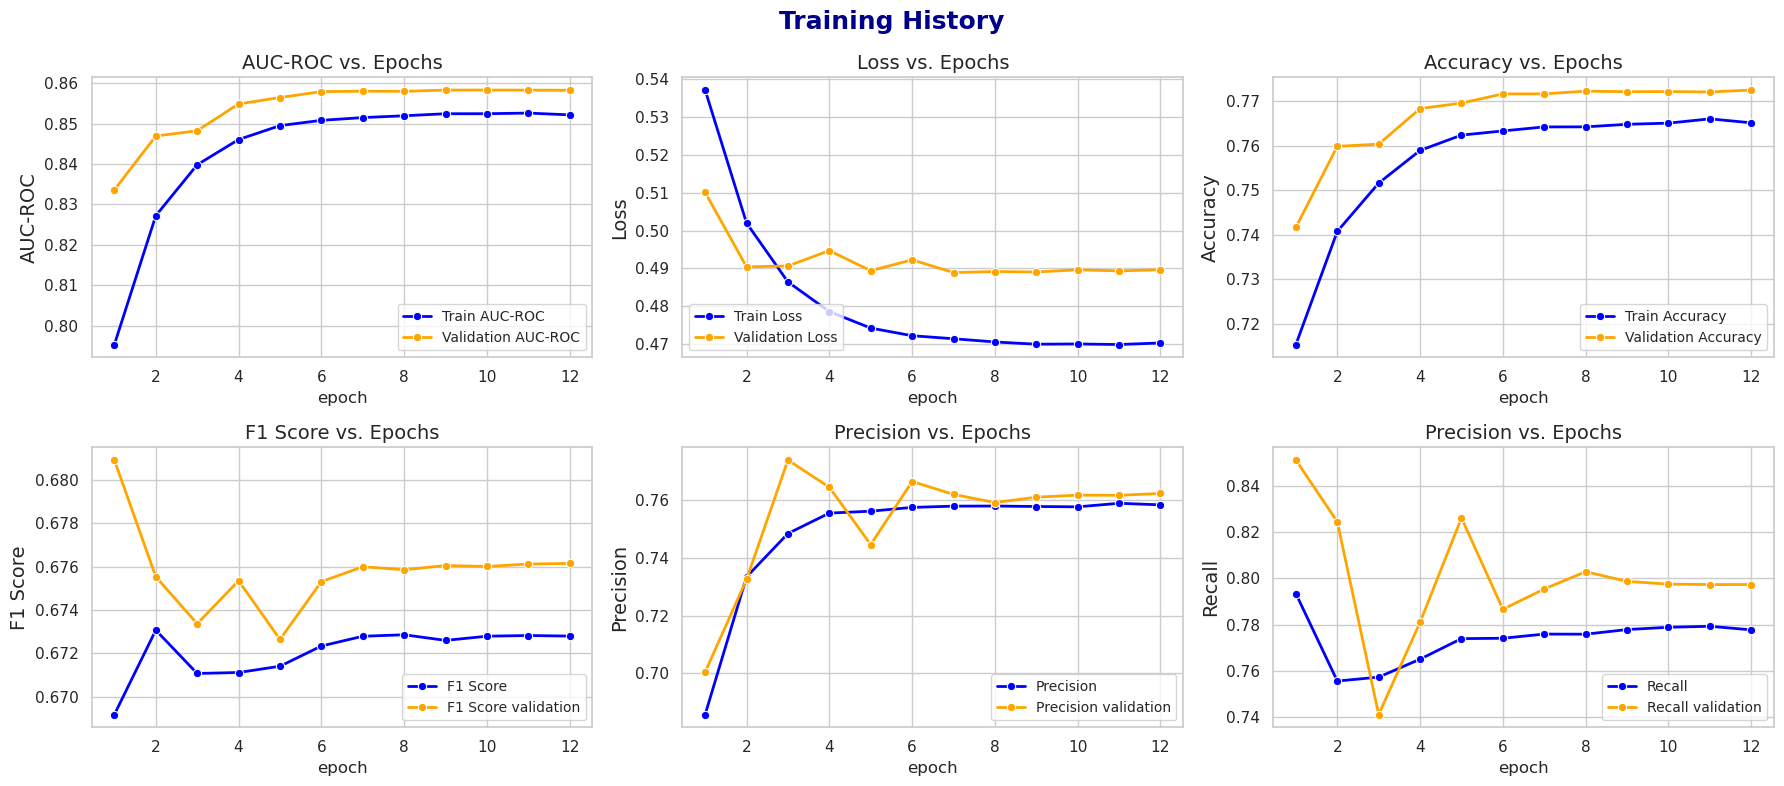

In [32]:
best = lambda x_col, y_col: (hist_df.iloc[2][x_col],hist_df.iloc[2][y_col])

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=False)
fig.suptitle("Training History", fontsize=18, fontweight="bold", color="darkblue")

# 1st subplot: AUC-ROC
sns.lineplot(data=hist_df, x='epoch', y='auc_roc', label='Train AUC-ROC', ax=axes[0, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=hist_df, x='epoch', y='val_auc_roc', label='Validation AUC-ROC', ax=axes[0, 0], color='orange', linewidth=2, marker='o')
# lambda arguments : expression
# axes[0].annotate(text='best', xy=best('epoch', 'val_auc_roc'))
axes[0, 0].set_ylabel("AUC-ROC", fontsize=14)
axes[0, 0].set_title("AUC-ROC vs. Epochs", fontsize=14)
axes[0, 0].legend(loc="lower right", fontsize=10)

# 2nd subplot: Loss
sns.lineplot(data=hist_df, x='epoch', y='loss', label='Train Loss', ax=axes[0, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=hist_df, x='epoch', y='val_loss', label='Validation Loss', ax=axes[0, 1], color='orange', linewidth=2, marker='o')
# axes[1].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[0, 1].set_ylabel("Loss", fontsize=14)
axes[0, 1].set_title("Loss vs. Epochs", fontsize=14)
axes[0, 1].legend(loc="lower left", fontsize=10)

# 3rd subplot: Accuracy
sns.lineplot(data=hist_df, x='epoch', y='binary_accuracy', label='Train Accuracy', ax=axes[0, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=hist_df, x='epoch', y='val_binary_accuracy', label='Validation Accuracy', ax=axes[0, 2], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[0, 2].set_ylabel("Accuracy", fontsize=14)
axes[0, 2].set_title("Accuracy vs. Epochs", fontsize=14)
axes[0, 2].legend(loc="lower right", fontsize=10)

# 4th subplot: F1-score
sns.lineplot(data=hist_df, x='epoch', y='f1_score', label='F1 Score', ax=axes[1, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=hist_df, x='epoch', y='val_f1_score', label='F1 Score validation', ax=axes[1, 0], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 0].set_ylabel("F1 Score", fontsize=14)
axes[1, 0].set_title("F1 Score vs. Epochs", fontsize=14)
axes[1, 0].legend(loc="lower right", fontsize=10)

# 5th subplot: F1-score
sns.lineplot(data=hist_df, x='epoch', y='precision', label='Precision', ax=axes[1, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=hist_df, x='epoch', y='val_precision', label='Precision validation', ax=axes[1, 1], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 1].set_ylabel("Precision", fontsize=14)
axes[1, 1].set_title("Precision vs. Epochs", fontsize=14)
axes[1, 1].legend(loc="lower right", fontsize=10)

# 6th subplot: F1-score
sns.lineplot(data=hist_df, x='epoch', y='recall', label='Recall', ax=axes[1, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=hist_df, x='epoch', y='val_recall', label='Recall validation', ax=axes[1, 2], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 2].set_ylabel("Recall", fontsize=14)
axes[1, 2].set_title("Precision vs. Epochs", fontsize=14)
axes[1, 2].legend(loc="lower right", fontsize=10)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for suptitle
plt.show()

### Inference

In [33]:
test_df = df.iloc[valid_idx]
test_data_gen = TrainDataGenerator(
    img_ids=test_df.index, 
    labels=test_df,
    img_dir=TRAIN_DATA_PATH,
    img_shape=(256, 256, 3),
    num_classes=1,
    batch_size=15,
    under_sampling=False,
    with_sample_weight=False,
    workers=128,
    use_multiprocessing=True
)

In [291]:
x_test, y_test = test_data_gen[4]

In [292]:
y_test_pred = model.model(x_test,training=False)

In [293]:
y_test = y_test.squeeze()
y_test_pred = y_test_pred.numpy().squeeze()

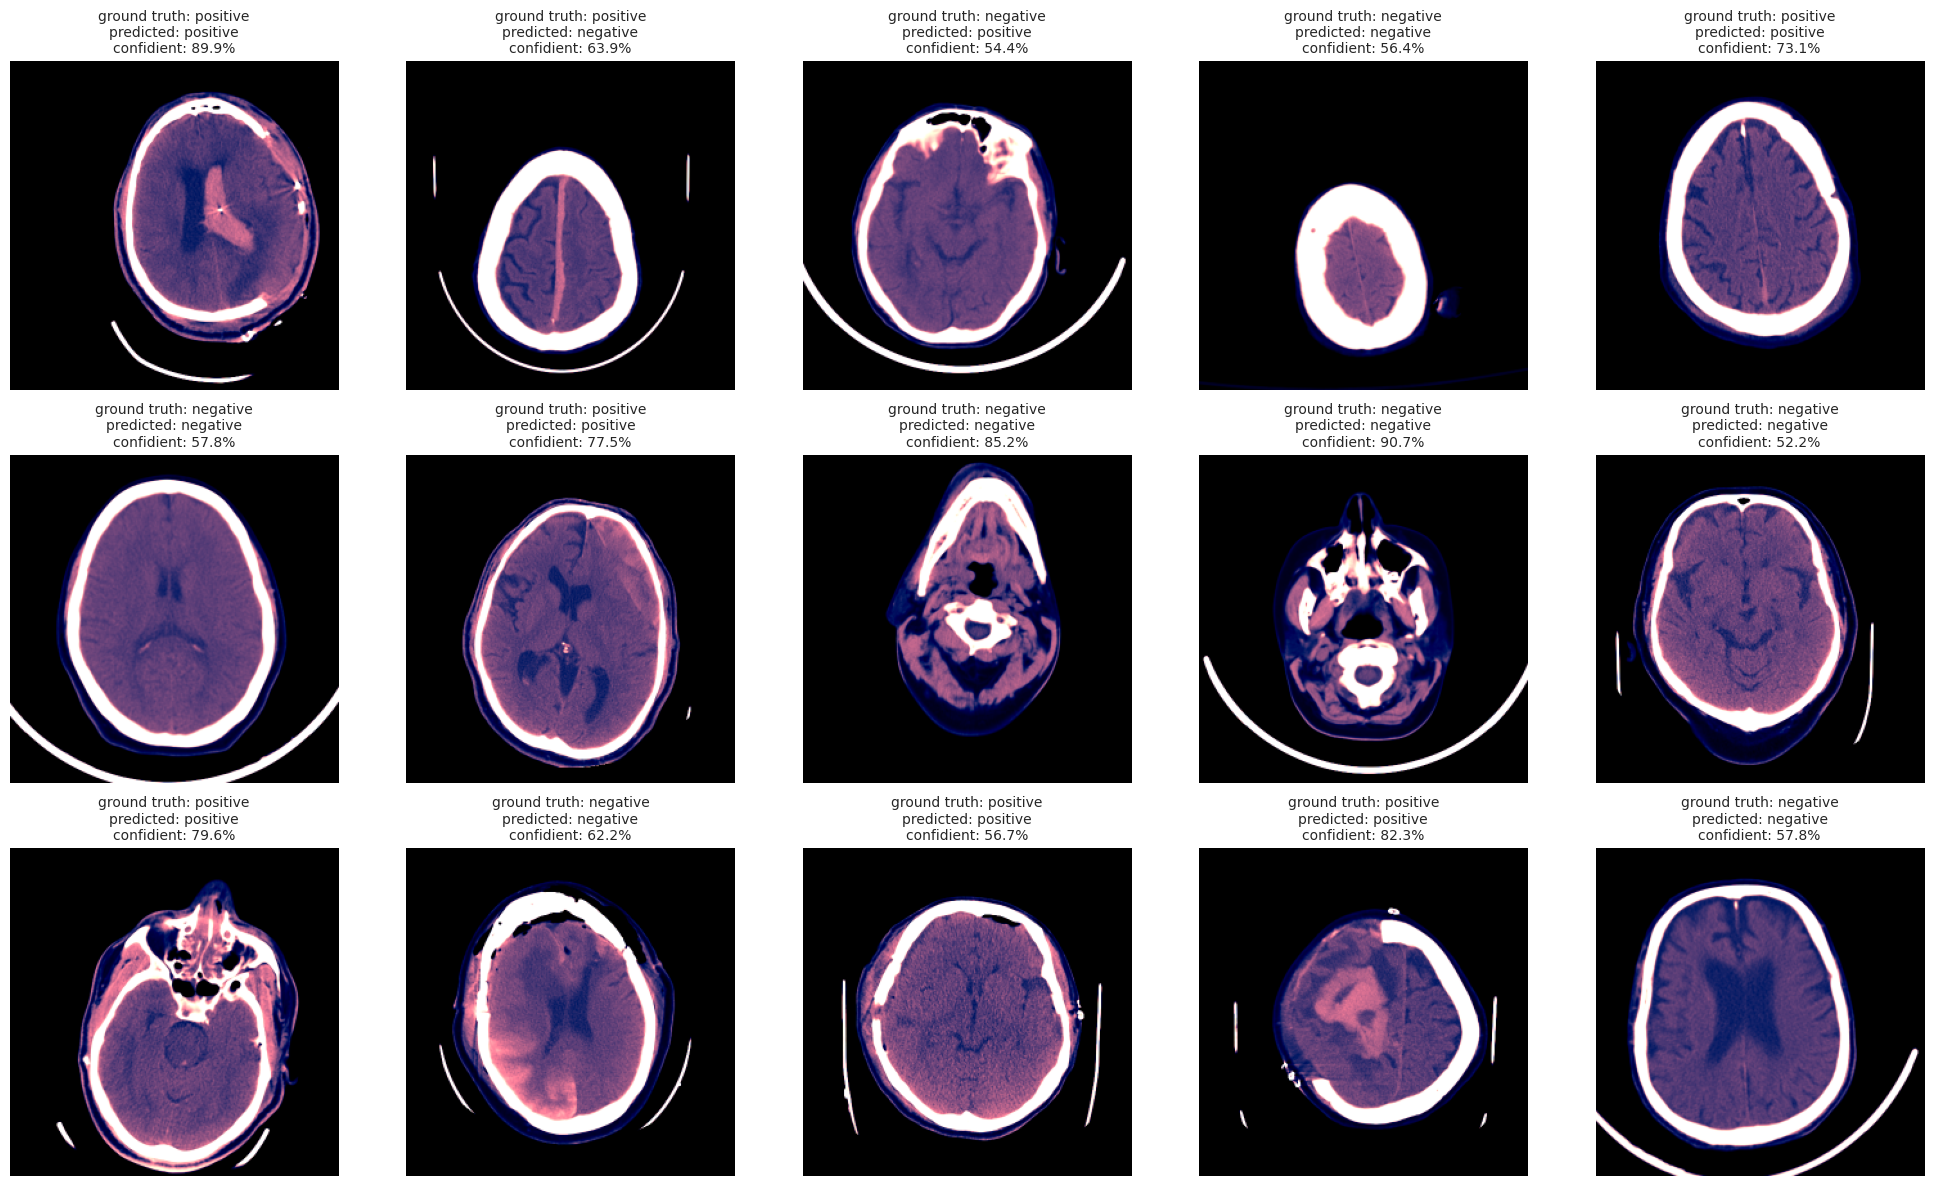

In [294]:
# sanity check
N, M = int(np.ceil(len(y_test_pred)/5)), 5
fig, axes = plt.subplots(N, M, figsize=(M*4,N*4))
for i, ax in enumerate(axes.flat):
    if i < len(y_test_pred):
        ground_truth = 'ground truth: ' + ('positive' if int(y_test[i]) == 1 else 'negative')
        predicted = '\npredicted: ' + ('positive' if y_test_pred[i] >= 0.5 else 'negative')
        confidient = '\nconfidient: ' + (f'{y_test_pred[i]*100:0.001f}%' if y_test_pred[i] >= 0.5 else f'{(1-y_test_pred[i])*100:0.001f}%')
        ax.imshow(x_test[i], cmap=plt.cm.bone)
        ax.axis('off')
        ax.set_title(ground_truth + predicted + confidient)
        ax.title.set_size(10)
    else:
        ax.axis('off')

fig.tight_layout()
fig.show()

In [365]:
class GradCAM():
	def __init__(self, model, classIdx, layerName=None):

		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):

		for layer in reversed(self.model.layers):
			if len(layer.output_shape) == 4:
				return layer.name

	
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):

		gradModel = keras.models.Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
                     
				self.model.output])

		with tf.GradientTape() as tape:
		
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		grads = tape.gradient(loss, convOutputs)

		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads


		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

	
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)


		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

	
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):

		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, 1-alpha, heatmap, alpha, 0)
	
		return (heatmap, output)

In [366]:
gc_model = keras.models.load_model('/workspace/saved_model/InceptionResNetV2/final_InceptionRestnetV2.keras')

In [185]:
gc_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 58,275,045 (222.30 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 2,625,540 (10.02 MB)

In [367]:
test_img_gc = x_test[0]

In [368]:
preds = gc_model.predict(test_img_gc[np.newaxis, ...])
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


array([[0.89872533]], dtype=float32)

In [369]:
grad_cam = GradCAM(gc_model, 0, 'conv_7b')

In [370]:
heatmap = grad_cam.compute_heatmap(test_img_gc[np.newaxis, ...], eps=1e-8)

/root/miniconda3/envs/capstone/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer']]. Received: the structure of inputs=*
  warnings.warn(


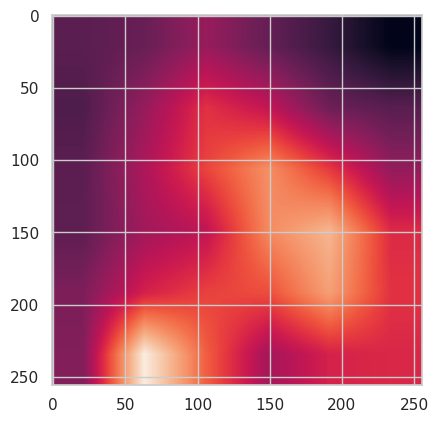

In [371]:
plt.imshow(heatmap)
plt.show()

In [372]:
test_img_gc_copy = np.copy(test_img_gc)
test_img_gc_copy -= test_img_gc_copy.min((0,1))
test_img_gc_copy = (255*test_img_gc_copy).astype(np.uint8)

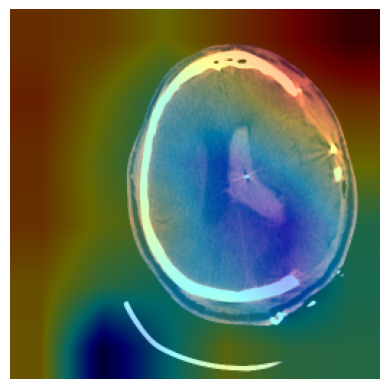

In [373]:
heatmap = cv2.resize(heatmap, (test_img_gc_copy.shape[1], test_img_gc_copy.shape[0]))
(heatmap, output) = grad_cam.overlay_heatmap(heatmap, test_img_gc_copy, alpha=0.4)
plt.imshow(output)
plt.axis('off')
plt.show()